In [1]:
import numpy as np
import numba as nb

#my library
from orderedTableSearch import locate, locate_grid

In [2]:
@nb.jit(nopython = True)
def fem2d_eleval(x, y, x0, x1, y0, y1, z0, z1, z2, z3):
# evaluate 2d element
#                
#           ||          ||
#           ||          ||
# y1 ------ z3 -------- z2 -------
#           ||          ||     
#           ||  (x, y)  ||     
#           ||    *     ||     
#           ||          ||
# y0 ------ z0 -------- z1 -------
#           ||          ||
#           ||          ||
#           x0          x1

    
    xi = (2.*x - x0 - x1)/(x1 - x0)
    eta = (2.*y - y0 - y1)/(y1 - y0)
    
    #To safely implement this part
    if x == x0:
        xi = -1.0
    elif x == x1:
        xi = 1.0
    
    if y == y0:
        eta = -1.0
    elif y == y1:
        eta = 1.0
    
    return ( (1. - xi)*(1. - eta)*z0 + 
             (1. + xi)*(1. - eta)*z1 + 
             (1. + xi)*(1. + eta)*z2 +             
             (1. - xi)*(1. + eta)*z3 ) / 4.0

@nb.jit(nopython = True)
def fem2d_peval(xval, yval, xnodes, ynodes, znodes):
    # Evaluate 2d FEM at a given point.
    # znodes is assumed to be array-like znodes = [xdim, ydim]
    # note that, if this is called for each points, it would be slow.
    
    #add a dimension check
    #if len(xnodes) != znodes.shape[0] or len(ynodes) != znodes.shape[1] 
    
    
    ix = locate(xval, xnodes)
    iy = locate(yval, ynodes)
    
    return fem2d_eleval(xval, yval, xnodes[ix], xnodes[ix+1], ynodes[iy], ynodes[iy+1],
                        znodes[ix, iy], znodes[ix+1, iy], znodes[ix+1, iy+1], znodes[ix, iy+1])

#make another function to evaluate on a grid or a line.

#!!!!!!CAUTION!!!!!! THIS FUNCTION MAY BE WRONG
@nb.jit(nopython = True)    
def fem2deval(xypoints, xnodes, ynodes, znodes): #, sort = False):

    #xypoint is array-like: xypoint[0,:] is x, xypoint[1,:] is y
    
    if xypoints.shape[0] != 2:
        print('ERROR: xypoints.shape[0] != 2')
        return None
    
    

    ans = np.zeros(xypoints.shape[1])
    
    
    #numba did not accept the following two arguments
    #ixs = np.empty(xypoints.shape[1]) 
    #iys = np.empty(xypoints.shape[1])

    ixs = locate_grid(xypoints[0,:], xnodes)
    iys = locate_grid(xypoints[1,:], ynodes)
    
    for i in range(len(ans)):
        ans[i] = fem2d_eleval(
            xypoints[0,i], xypoints[1,i], xnodes[ixs[i]], xnodes[ixs[i]+1], ynodes[iys[i]], ynodes[iys[i]+1],
            znodes[ixs[i], iys[i]], znodes[ixs[i]+1, iys[i]], znodes[ixs[i]+1, iys[i]+1], znodes[ixs[i], iys[i]+1])
    
    return ans
    
    


In [3]:
@nb.jit(nopython = True)    
def fem2deval_mesh(xs, ys, xnodes, ynodes, znodes): #, sort = False):
    
    #I assume xs and ys are strictly accending
    
    num_x = len(xs)
    num_y = len(ys)
    
    ixs = locate_grid(xs, xnodes)
    iys = locate_grid(ys, ynodes)
    
    zs = np.ones((num_x, num_y)) #be careful with the direction
    
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            
            zs[ix, iy] = fem2d_eleval(
                x, y, xnodes[ixs[ix]], xnodes[ixs[ix]+1], ynodes[iys[iy]], ynodes[iys[iy]+1],
                znodes[ixs[ix], iys[iy]], znodes[ixs[ix]+1, iys[iy]],
                znodes[ixs[ix]+1, iys[iy]+1], znodes[ixs[ix], iys[iy]+1])

    return zs
    
    
    

In [4]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("savefig",dpi=100)
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import linalg as LA
from scipy.optimize import fsolve
from numpy.polynomial.legendre import leggauss
#import numdifftools as nd

import time

#display options
np.set_printoptions(precision=3, linewidth = 120)

In [5]:
#put a more elementary example

In [6]:
#interpolate this function
def f(x,y):
    return np.exp((x**2.0 + y**2.0) )

nodes = np.linspace(-1, 1, 7) #over this region (with some extrapolation)
xxnodes, yynodes = np.meshgrid(nodes, nodes)
zz = f(xxnodes, yynodes)

xynodes = np.array((xxnodes.flatten(), yynodes.flatten())) #a set of coordinates

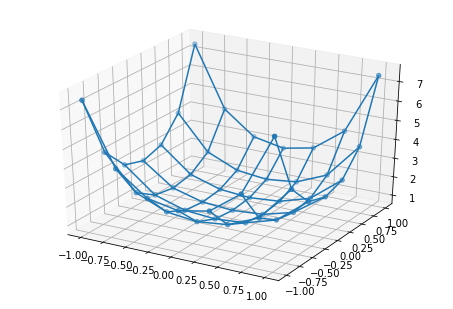

In [7]:
fig = plt.figure()
ax = Axes3D(fig)

#xxnodes, yynodes = np.meshgrid(nodes, nodes)
ax.plot_wireframe(xxnodes, yynodes, zz)
ax.scatter(xxnodes, yynodes, zz)
plt.show()

In [8]:
#check if the two coinsice with each other
np.allclose(fem2deval(xynodes, nodes, nodes, zz) - zz.flatten(), 0.)

True

In [9]:
fem2deval(xynodes, nodes, nodes, zz) 

array([ 7.389,  4.239,  3.038,  2.718,  3.038,  4.239,  7.389,  4.239,  2.432,  1.743,  1.56 ,  1.743,  2.432,  4.239,
        3.038,  1.743,  1.249,  1.118,  1.249,  1.743,  3.038,  2.718,  1.56 ,  1.118,  1.   ,  1.118,  1.56 ,  2.718,
        3.038,  1.743,  1.249,  1.118,  1.249,  1.743,  3.038,  4.239,  2.432,  1.743,  1.56 ,  1.743,  2.432,  4.239,
        7.389,  4.239,  3.038,  2.718,  3.038,  4.239,  7.389])

In [10]:
nodes

array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ])

In [11]:
from scipy.interpolate import RectBivariateSpline

In [12]:
RectBivariateSpline(nodes, nodes, zz,kx = 1, ky = 1)(nodes, nodes)

array([[ 7.389,  4.239,  3.038,  2.718,  3.038,  4.239,  7.389],
       [ 4.239,  2.432,  1.743,  1.56 ,  1.743,  2.432,  4.239],
       [ 3.038,  1.743,  1.249,  1.118,  1.249,  1.743,  3.038],
       [ 2.718,  1.56 ,  1.118,  1.   ,  1.118,  1.56 ,  2.718],
       [ 3.038,  1.743,  1.249,  1.118,  1.249,  1.743,  3.038],
       [ 4.239,  2.432,  1.743,  1.56 ,  1.743,  2.432,  4.239],
       [ 7.389,  4.239,  3.038,  2.718,  3.038,  4.239,  7.389]])

In [13]:
fem2deval_mesh(nodes,nodes, nodes, nodes, zz) - RectBivariateSpline(nodes, nodes, zz,kx = 1, ky = 1)(nodes, nodes)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

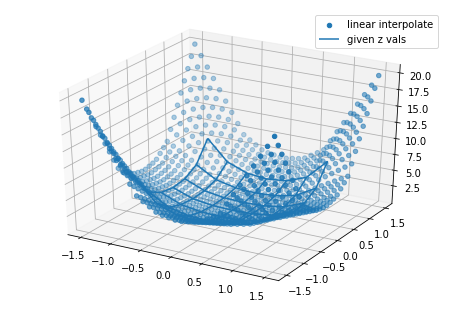

In [14]:
#inter- and extra- polate
vals =  np.linspace(-1.5, 1.5, 30)
xxvals, yyvals = np.meshgrid(vals, vals)
xyvals = np.array((xxvals.flatten(), yyvals.flatten()))
zvals = fem2deval(xyvals, nodes, nodes, zz)


fig = plt.figure()
ax = Axes3D(fig)

#ax.plot_wireframe(xx, yy, zz)
ax.scatter(xxvals, yyvals, zvals, label = 'linear interpolate')
ax.plot_wireframe(xxnodes, yynodes, zz, label = 'given z vals')
plt.legend()
plt.show()

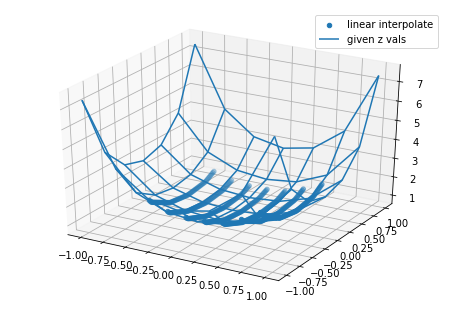

In [17]:
#inter- and extra- polate
xvals = np.linspace(-0.5, 0.7, 7)
yvals = np.linspace(-0.7, 0.5, 60)
xxvals, yyvals = np.meshgrid(xvals, yvals)

xyvals = np.array((xxvals.flatten(), yyvals.flatten()))
# zvals = fem2deval(xyvals, nodes, nodes, zz)

zvals = fem2deval_mesh(xvals ,yvals, nodes, nodes, zz)
zvals2 = RectBivariateSpline(nodes, nodes, zz,kx = 1, ky = 1)(xvals, yvals)

fig = plt.figure()
ax = Axes3D(fig)

#ax.plot_wireframe(xx, yy, zz)
ax.scatter(xxvals, yyvals, zvals.T, label = 'linear interpolate')
ax.plot_wireframe(xxnodes, yynodes, zz.T, label = 'given z vals')
plt.legend()
plt.show()



In [18]:
zvals - zvals2

array([[  0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   2.220e-16,  -2.220e-16,   4.441e-16,
         -2.220e-16,   0.000e+00,  -2.220e-16,   0.000e+00,  -2.220e-16,   0.000e+00,   0.000e+00,   0.000e+00,
          0.000e+00,   0.000e+00,   0.000e+00,   4.441e-16,   0.000e+00,   6.661e-16,   2.220e-16,   0.000e+00,
          4.441e-16,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   2.220e-16,   0.000e+00,
          0.000e+00,   0.000e+00,   0.000e+00,  -2.220e-16,   2.220e-16,   2.220e-16,   0.000e+00,   0.000e+00,
         -2.220e-16,   0.000e+00,   0.000e+00,   0.000e+00,  -4.441e-16,   0.000e+00,  -2.220e-16,   0.000e+00,
          0.000e+00,   0.000e+00,   0.000e+00,  -2.220e-16,  -2.220e-16,  -2.220e-16,   0.000e+00,   2.220e-16,
          0.000e+00,   0.000e+00,  -2.220e-16,  -2.220e-16],
       [ -2.220e-16,  -2.220e-16,   0.000e+00,   0.000e+00,   2.220e-16,   0.000e+00,  -2.220e-16,   4.441e-16,
          0.000e+00,   0.000e+00,   0.000e+

In [254]:
1 // 10

0

In [268]:
@nb.jit(nopython = True)    
def unravel_index_2d(num, dim_x, dim_y):
    
    ind_y = (num) % dim_y 
    ind_x = (num ) // dim_y
    
    return ind_x, ind_y

In [270]:
for i in range(0,100):
    print(unravel_index_2d(i, 7, 13), end = '')
    print(np.unravel_index(i, (7, 13)))

(0, 0)(0, 0)
(0, 1)(0, 1)
(0, 2)(0, 2)
(0, 3)(0, 3)
(0, 4)(0, 4)
(0, 5)(0, 5)
(0, 6)(0, 6)
(0, 7)(0, 7)
(0, 8)(0, 8)
(0, 9)(0, 9)
(0, 10)(0, 10)
(0, 11)(0, 11)
(0, 12)(0, 12)
(1, 0)(1, 0)
(1, 1)(1, 1)
(1, 2)(1, 2)
(1, 3)(1, 3)
(1, 4)(1, 4)
(1, 5)(1, 5)
(1, 6)(1, 6)
(1, 7)(1, 7)
(1, 8)(1, 8)
(1, 9)(1, 9)
(1, 10)(1, 10)
(1, 11)(1, 11)
(1, 12)(1, 12)
(2, 0)(2, 0)
(2, 1)(2, 1)
(2, 2)(2, 2)
(2, 3)(2, 3)
(2, 4)(2, 4)
(2, 5)(2, 5)
(2, 6)(2, 6)
(2, 7)(2, 7)
(2, 8)(2, 8)
(2, 9)(2, 9)
(2, 10)(2, 10)
(2, 11)(2, 11)
(2, 12)(2, 12)
(3, 0)(3, 0)
(3, 1)(3, 1)
(3, 2)(3, 2)
(3, 3)(3, 3)
(3, 4)(3, 4)
(3, 5)(3, 5)
(3, 6)(3, 6)
(3, 7)(3, 7)
(3, 8)(3, 8)
(3, 9)(3, 9)
(3, 10)(3, 10)
(3, 11)(3, 11)
(3, 12)(3, 12)
(4, 0)(4, 0)
(4, 1)(4, 1)
(4, 2)(4, 2)
(4, 3)(4, 3)
(4, 4)(4, 4)
(4, 5)(4, 5)
(4, 6)(4, 6)
(4, 7)(4, 7)
(4, 8)(4, 8)
(4, 9)(4, 9)
(4, 10)(4, 10)
(4, 11)(4, 11)
(4, 12)(4, 12)
(5, 0)(5, 0)
(5, 1)(5, 1)
(5, 2)(5, 2)
(5, 3)(5, 3)
(5, 4)(5, 4)
(5, 5)(5, 5)
(5, 6)(5, 6)
(5, 7)(5, 7)
(5, 8)(5, 8)
(5, 9)(5

ValueError: invalid entry in index array

In [250]:
unravel_index_2d(np.argmin(zvals), 7,60)

(6, 54)

In [251]:
np.unravel_index(np.argmin(zvals), dims = ( 7, 60))

(6, 24)

In [214]:
np.argmin(zvals)

174

In [245]:
zvals[6, 24]

1.0059755458682302

In [215]:
zvals.flatten()[174]

1.0059755458682302

In [236]:
zvals

array([[ 12.113,  11.457,  10.801,  10.144,   9.488,   8.832,   8.175,   7.519,   6.917,   6.666,   6.416,   6.165,
          5.915,   5.665,   5.414,   5.164,   4.962,   4.896,   4.829,   4.762,   4.696,   4.629,   4.563,   4.496,
          4.483,   4.549,   4.616,   4.683,   4.749,   4.816,   4.882,   4.949,   5.114,   5.364,   5.614,   5.865,
          6.115,   6.366,   6.616,   6.867,   7.388,   8.044,   8.7  ,   9.357,  10.013,  10.669,  11.326,  11.982,
         12.638,  13.295,  13.951,  14.608,  15.264,  15.92 ,  16.577,  17.233,  17.889,  18.546,  19.202,  19.858],
       [  9.751,   9.223,   8.695,   8.166,   7.638,   7.109,   6.581,   6.053,   5.568,   5.366,   5.165,   4.963,
          4.762,   4.56 ,   4.358,   4.157,   3.995,   3.941,   3.887,   3.834,   3.78 ,   3.727,   3.673,   3.619,
          3.609,   3.662,   3.716,   3.769,   3.823,   3.877,   3.93 ,   3.984,   4.116,   4.318,   4.52 ,   4.721,
          4.923,   5.124,   5.326,   5.528,   5.947,   6.475,   7.004, 

In [235]:
np.argmin(zvals)

384

(0, 0)(0, 0)
(1, 0)(0, 1)
(2, 0)(0, 2)
(3, 0)(0, 3)
(4, 0)(0, 4)
(5, 0)(0, 5)
(6, 0)(0, 6)
(7, 0)(0, 7)
(8, 0)(0, 8)
(9, 0)(0, 9)
(10, 0)(0, 10)
(11, 0)(0, 11)
(0, 1)(0, 12)
(1, 1)(1, 0)
(2, 1)(1, 1)
(3, 1)(1, 2)
(4, 1)(1, 3)
(5, 1)(1, 4)
(6, 1)(1, 5)
(7, 1)(1, 6)
(8, 1)(1, 7)
(9, 1)(1, 8)
(10, 1)(1, 9)
(11, 1)(1, 10)
(0, 2)(1, 11)
(1, 2)(1, 12)
(2, 2)(2, 0)
(3, 2)(2, 1)
(4, 2)(2, 2)
(5, 2)(2, 3)
(6, 2)(2, 4)
(7, 2)(2, 5)
(8, 2)(2, 6)
(9, 2)(2, 7)
(10, 2)(2, 8)
(11, 2)(2, 9)
(0, 3)(2, 10)
(1, 3)(2, 11)
(2, 3)(2, 12)
(3, 3)(3, 0)
(4, 3)(3, 1)
(5, 3)(3, 2)
(6, 3)(3, 3)
(7, 3)(3, 4)
(8, 3)(3, 5)
(9, 3)(3, 6)
(10, 3)(3, 7)
(11, 3)(3, 8)
(0, 4)(3, 9)
(1, 4)(3, 10)
(2, 4)(3, 11)
(3, 4)(3, 12)
(4, 4)(4, 0)
(5, 4)(4, 1)
(6, 4)(4, 2)
(7, 4)(4, 3)
(8, 4)(4, 4)
(9, 4)(4, 5)
(10, 4)(4, 6)
(11, 4)(4, 7)
(0, 5)(4, 8)
(1, 5)(4, 9)
(2, 5)(4, 10)
(3, 5)(4, 11)
(4, 5)(4, 12)
(5, 5)(5, 0)
(6, 5)(5, 1)
(7, 5)(5, 2)
(8, 5)(5, 3)
(9, 5)(5, 4)
(10, 5)(5, 5)
(11, 5)(5, 6)
(0, 6)(5, 7)
(1, 6)(5, 8)
(2, 6)(5, 9